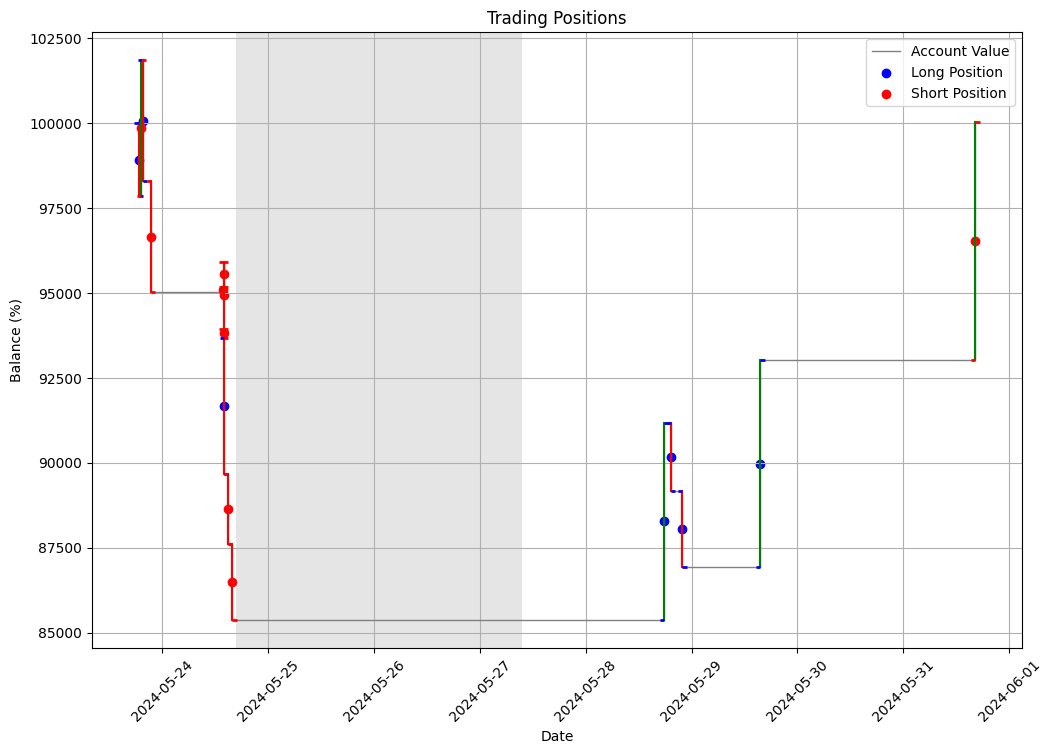

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Variable to switch between percentage and real price
USE_PERCENTAGE = True


# Load the CSV file
file_path = './data/test.csv'  # Adjust the file path as needed

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Extract date and price information
df['Time'] = pd.to_datetime(df['Time'])
df['Price'] = df['Action'].str.extract(r'at price (\d+\.\d+)').astype(float)
df['Position'] = df['Action'].str.contains('Close long position')

# Create a new DataFrame for the account value line
df.sort_values('Time', inplace=True)

# Interleave 'Balance Before' and 'Balance After' values
balance_values = df[['Balance Before', 'Balance After']].values.flatten()

# Duplicate 'Time' values and sort by original order
time_values = df['Time'].repeat(2).reset_index(drop=True)

# Create a new DataFrame for the account value line
account_value = pd.DataFrame({
    'Time': time_values,
    'Balance': balance_values
})
# Plot the prices
fig, ax = plt.subplots(figsize=(12, 8))

# Add a line for the account value
plt.plot(account_value['Time'], account_value['Balance'], color='gray', linewidth=1, label='Account Value')

# Iterate over DataFrame rows
for i, row in df.iterrows():
    color = 'green' if row['Balance After'] > row['Balance Before'] else 'red'
    plt.plot([row['Time'], row['Time']], [row['Balance Before'], row['Balance After']], color=color)
    # Add a colored marker in the middle of the vertical bar

    
# Mark long and short positions
long_positions = df[df['Position']]
short_positions = df[~df['Position']]

# Add small horizontal lines at the beginning and end of a balance for long positions
for i, row in long_positions.iterrows():
    plt.hlines(y=row['Balance Before'], xmin=row['Time'] - pd.Timedelta(hours=1), xmax=row['Time'], color='blue', linewidth=2)
    plt.hlines(y=row['Balance After'], xmin=row['Time'], xmax=row['Time'] + pd.Timedelta(hours=1), color='blue', linewidth=2)
    
    middle_balance = (row['Balance Before'] + row['Balance After']) / 2
    plt.scatter(row['Time'], middle_balance, color='blue')
    
    
# Add small horizontal lines at the beginning and end of a balance for short positions
for i, row in short_positions.iterrows():
    plt.hlines(y=row['Balance Before'], xmin=row['Time'] - pd.Timedelta(hours=1), xmax=row['Time'], color='red', linewidth=2)
    plt.hlines(y=row['Balance After'], xmin=row['Time'], xmax=row['Time'] + pd.Timedelta(hours=1), color='red', linewidth=2)
    middle_balance = (row['Balance Before'] + row['Balance After']) / 2
    plt.scatter(row['Time'], middle_balance, color='red')
    
# Create dummy scatter plots for legend
plt.scatter([], [], color='blue', label='Long Position')
plt.scatter([], [], color='red', label='Short Position')

# Shade weekends
weekends = pd.date_range(start=df['Time'].min(), end=df['Time'].max(), freq='W-THU')
for weekend in weekends:
    start_time = weekend + pd.Timedelta(hours=22)  # Friday 10pm
    end_time = weekend + pd.Timedelta(days=3, hours=15)  # Monday 3pm
    ax.axvspan(start_time, end_time, facecolor='gray', alpha=0.2)
    
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Balance (%)' if USE_PERCENTAGE else 'Balance')
plt.title('Trading Positions')
plt.legend()
plt.grid(True)
plt.show()

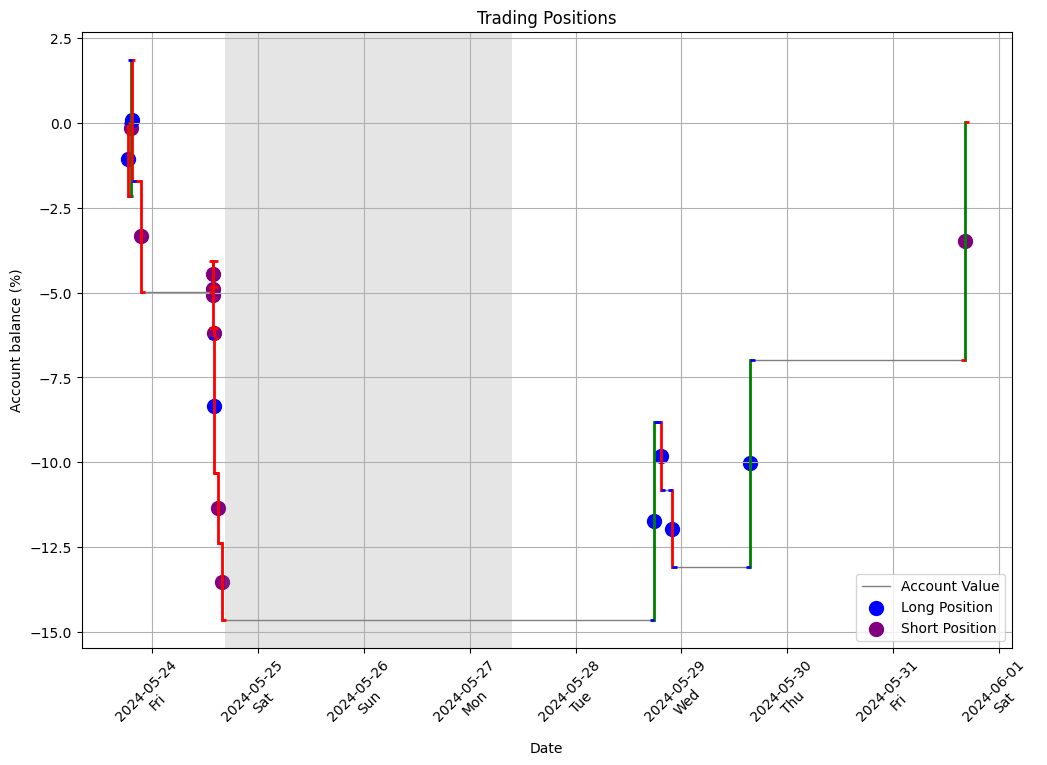

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

USE_PERCENTAGE = True  # Change to True to use percentage values



def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df['Price'] = df['Action'].str.extract(r'at price (\d+\.\d+)').astype(float)
    df['Position'] = df['Action'].str.contains('Close long position')
    return df.sort_values('Time')

def create_account_value_dataframe(df):
    return pd.DataFrame({
        'Time': df['Time'].repeat(2).reset_index(drop=True),
        'Balance': df[['Balance Before', 'Balance After']].values.flatten()
    })

def plot_account_value(account_value, ax, use_percentage):
    balance = account_value['Balance']
    if use_percentage:
        balance = (balance / balance.iloc[0] - 1) * 100
    ax.plot(account_value['Time'], balance, color='gray', linewidth=1, label='Account Value')
    ax.set_ylabel('Account balance (%)' if use_percentage else 'Account balance (USD)')

def plot_positions(df, ax, use_percentage):
    labeled = {'Long Position': False, 'Short Position': False}
    for _, row in df.iterrows():
        balance_before = row['Balance Before']
        balance_after = row['Balance After']
        if use_percentage:
            initial_balance = df['Balance Before'].iloc[0]
            balance_before = (balance_before / initial_balance - 1) * 100
            balance_after = (balance_after / initial_balance - 1) * 100

        color = 'green' if balance_after > balance_before else 'red'
        ax.plot([row['Time'], row['Time']], [balance_before, balance_after], color=color, linewidth=2)

        if row['Position']:  # long positions
            ax.hlines(y=balance_before, xmin=row['Time'] - pd.Timedelta(hours=1), xmax=row['Time'], color='blue', linewidth=2)
            ax.hlines(y=balance_after, xmin=row['Time'], xmax=row['Time'] + pd.Timedelta(hours=1), color='blue', linewidth=2)
            middle_balance = (balance_before + balance_after) / 2
            label = 'Long Position' if not labeled['Long Position'] else None
            ax.scatter(row['Time'], middle_balance, color='blue', label=label, s=100)
            labeled['Long Position'] = True
        else: # short positions
            ax.hlines(y=balance_before, xmin=row['Time'] - pd.Timedelta(hours=1), xmax=row['Time'], color='red', linewidth=2)
            ax.hlines(y=balance_after, xmin=row['Time'], xmax=row['Time'] + pd.Timedelta(hours=1), color='red', linewidth=2)
            middle_balance = (balance_before + balance_after) / 2
            label = 'Short Position' if not labeled['Short Position'] else None
            ax.scatter(row['Time'], middle_balance, color='purple', label=label, s=100)
            labeled['Short Position'] = True

    ax.legend(loc='lower right')  # move legend to bottom right

def shade_weekends(df, ax):
    weekends = pd.date_range(start=df['Time'].min(), end=df['Time'].max(), freq='W-THU')
    for weekend in weekends:
        ax.axvspan(weekend + pd.Timedelta(hours=22), weekend + pd.Timedelta(days=3, hours=15), facecolor='gray', alpha=0.2)

def main():
    file_path = './data/test.csv'
    df = load_and_prepare_data(file_path)
    account_value = create_account_value_dataframe(df)

    fig, ax = plt.subplots(figsize=(12, 8))
    plot_account_value(account_value, ax, USE_PERCENTAGE)
    plot_positions(df, ax, USE_PERCENTAGE)  # pass use_percentage here
    shade_weekends(df, ax)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%a'))
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.title('Trading Positions')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()